# 0.0 General Imports

In [99]:
import pandas as pd
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import matplotlib.gridspec as gs
import xgboost as xgb
import pickle

from IPython.display         import Image
from tabulate                import tabulate
from scipy                   import stats as ss
from sklearn.preprocessing   import RobustScaler, LabelEncoder
from boruta                  import BorutaPy
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.model_selection import RandomizedSearchCV

# Float format 
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

# Graph font adjust
plt.rcParams.update({'font.size': 14})   

## 0.1 Helper Functions

In [100]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def metrics(num_attributes):
    return pd.DataFrame({'%missing': num_attributes.isna().mean(),                            # % of missing values
              'uniques': num_attributes.nunique(),                                            # number of unique values
              '%unique': round((num_attributes.nunique()/num_attributes.shape[0])*100, 2),    # % of unique values
              'data_types': num_attributes.dtypes,
              'mean': round(num_attributes.mean(), 2),
              'median': round(num_attributes.median(), 2),
              'std': round(num_attributes.std(), 2),
              'min': round(num_attributes.min(), 2),
              'max': round(num_attributes.max(), 2),
              'skew': num_attributes.skew(),
              'kurtosis': num_attributes.kurtosis()})


def ml_error(model_name, y, y_hat):
    mae = mean_absolute_error(y, y_hat)
    mape = mean_absolute_percentage_error(y, y_hat)
    rsme = np.sqrt(mean_squared_error(y, y_hat))
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rsme}, index=[0])



def mean_absolute_percentage_error(y, y_hat):
    return np.mean(np.abs((y - y_hat)/y))



def mean_percentage_error(y, y_hat):
    return np.mean((y - y_hat)/y)



def cross_validation(kfold, x_training, model_name, model):
    mae_list = []
    mape_list = []
    rsme_list = []
    for k in range(1, kfold+1):
        #print(f'\nKFold Number: {k}')
        
        # Start and end day for validation
        validation_start_day = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_day = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # Filter dataset - train | validation
        train = x_training[x_training['date'] < validation_start_day]
        validation = x_training[(x_training['date'] <= validation_end_day)&(x_training['date'] >= validation_start_day)]

        ## Drop the 'date' and 'sales' to train
        # Training
        ytraining = train['sales']
        xtraining = train.drop(columns={'date', 'sales'})

        # Validation
        yvalidation = validation['sales']
        xvalidation = validation.drop(columns={'date', 'sales'})

        # Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # Performance
        m_result = ml_error(model_name, y=np.expm1(yvalidation), y_hat=np.expm1(yhat))

        # Store performance metrics of each iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rsme_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE_CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE_CV': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE_CV': np.round(np.mean(rsme_list), 2).astype(str) + '+/-' + np.round(np.std(rsme_list), 2).astype(str)}, index=[0])



## 0.2 Loading Data

In [101]:
# Loading raw data with including Sales
df_sales_raw = pd.read_csv(r'data/train.csv', low_memory=False)

# Supplemental information about the stores
df_store_raw = pd.read_csv(r'data/store.csv', low_memory=False)

# Merging the both dataframes
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.00,6.00,2014.00,1,31.00,2013.00,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.00,4.00,2006.00,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.00,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.00,NaN,NaN,0,NaN,NaN,NaN


# 1.0 Data Description


In [102]:
# Create a copy every new section
df1 = df_raw.copy()

## 1.1 Rename Columns
- The name of columns will be rename to facilitate the treatment of the data

In [103]:
# Get the list of columns name
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [104]:
# Old columns
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']

# Function: Transform to snake case
snake_case =  lambda x: inflection.underscore(x)

# CaLL function to New columns
new_cols = list(map(snake_case, old_cols))

# Rename
df1.columns = new_cols

## 1.2 Data Dimensions

In [105]:
print(f'Number of rows: {df1.shape[0]}.')
print(f'Number of columns: {df1.shape[1]}.')

Number of rows: 1017209.
Number of columns: 18.


## 1.3 Data Types

In [106]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [107]:
# Transform 'date': 'object' to 'datetime'
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA Values

In [108]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA Values



In [109]:
# competition_distance = distance in meters to the nearest competitor store
# Assumption: if is NA, there is no competition nearby (Distance too high).
# Action: if NA, put a huge distance of 200000
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

In [110]:
# competition_open_since_month = gives the approximate month of the time the nearest competitor was opened
# Assumption: if there is a near competition, do not know the date that was opened.
# Action: if NA, put the month of the sale 
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
                                                if math.isnan(x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis=1)

In [111]:
# competition_open_since_year = gives the approximate year of the time the nearest competitor was opened
# Assumption: same as month.
# Action: same as month.
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year
                                                if math.isnan(x['competition_open_since_year']) 
                                                else x['competition_open_since_year'], axis=1)

In [112]:
# promo2_since_week =  describes the calendar week when the store started participating in Promo2 (consecutive promotion)
# Assumption: 'NA' means that the store did not continue the promo2.
# Action: if NA, replace by the week date of the sale
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week
                                                if math.isnan(x['promo2_since_week']) 
                                                else x['promo2_since_week'], axis=1)

In [113]:
# promo2_since_year =  describes the year when the store started participating in Promo2
# Assumption: 'NA' means that the store did not continue the promo2.
# Action: if NA, replace by the year date of the sale
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year
                                                if math.isnan(x['promo2_since_year']) 
                                                else x['promo2_since_year'], axis=1)

In [114]:
# promo_interval = describes the consecutive intervals Promo2 is started.
# Assumption: Check if the sale was in promo, mapping if the month of the date is in promo_interval.
# Action: Create a new attribute boolean 1|0 if is in promo start month or not.
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
             9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# Fill 'NA' with 0
df1['promo_interval'].fillna(0, inplace=True)

# Create column month_map to map
df1['month_map'] = df1['date'].dt.month.map(month_map)

# Check if sale is in promo by date
df1['is_promo'] = df1.apply(lambda x: 0 if x['promo_interval']==0 
                            else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6 Change Dtypes


In [115]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [116]:
# Change float64 to int32
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical 

In [117]:
# Separate the attributes between numerical and categorical
num_attributes = df1.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64'])

### 1.7.1 Numerical Attributes

In [118]:
# Call Function: descriptive statistical metrics
metrics(num_attributes)

,%missing,uniques,%unique,data_types,mean,median,std,min,max,skew,kurtosis
store,0.00,1115,0.11,int64,558.43,558.00,321.91,1.00,1115.00,-0.00,-1.20
day_of_week,0.00,7,0.00,int64,4.00,4.00,2.00,1.00,7.00,0.00,-1.25
sales,0.00,21734,2.14,int64,5773.82,5744.00,3849.93,0.00,41551.00,0.64,1.78
customers,0.00,4086,0.40,int64,633.15,609.00,464.41,0.00,7388.00,1.60,7.09
open,0.00,2,0.00,int64,0.83,1.00,0.38,0.00,1.00,-1.76,1.09
promo,0.00,2,0.00,int64,0.38,0.00,0.49,0.00,1.00,0.49,-1.76
school_holiday,0.00,2,0.00,int64,0.18,0.00,0.38,0.00,1.00,1.68,0.82
competition_distance,0.00,655,0.06,float64,5935.44,2330.00,12547.65,20.00,200000.00,10.24,147.79
competition_open_since_month,0.00,12,0.00,int32,6.79,7.00,3.31,1.00,12.00,-0.04,-1.23
competition_open_since_year,0.00,23,0.00,int32,2010.32,2012.00,5.52,1900.00,2015.00,-7.24,124.07


### 1.7.2 Categorical Attributes

In [119]:
# Check unique values
cat_attributes.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

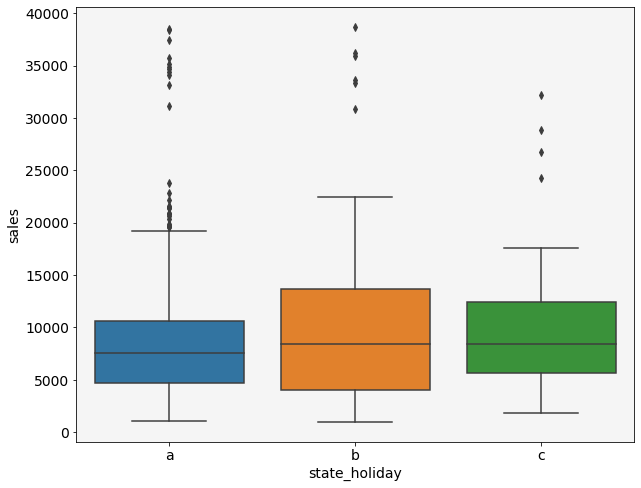

In [120]:
# Filter of non-zero values
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)] 

# Boxplot of state_holiday
plt.figure(figsize=(10,8))
sns.boxplot(x=aux1['state_holiday'], y=aux1['sales']).set_facecolor('whitesmoke');

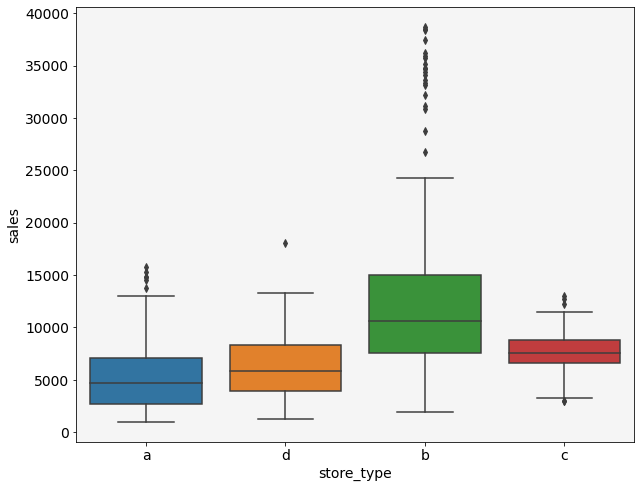

In [121]:
# Boxplot of store_type
plt.figure(figsize=(10,8))
sns.boxplot(x=aux1['store_type'], y=aux1['sales']).set_facecolor('whitesmoke');

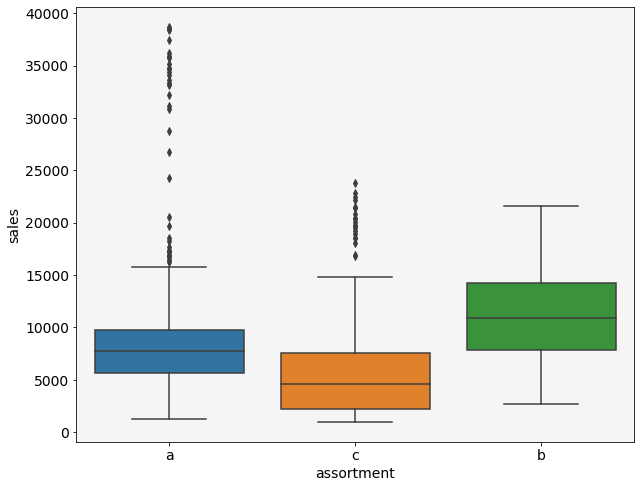

In [122]:
# Boxplot of assortment
plt.figure(figsize=(10,8))
sns.boxplot(x=aux1['assortment'], y=aux1['sales']).set_facecolor('whitesmoke');

# 2.0 Feature Engineering

## 2.1 Mind Map Hypotheses

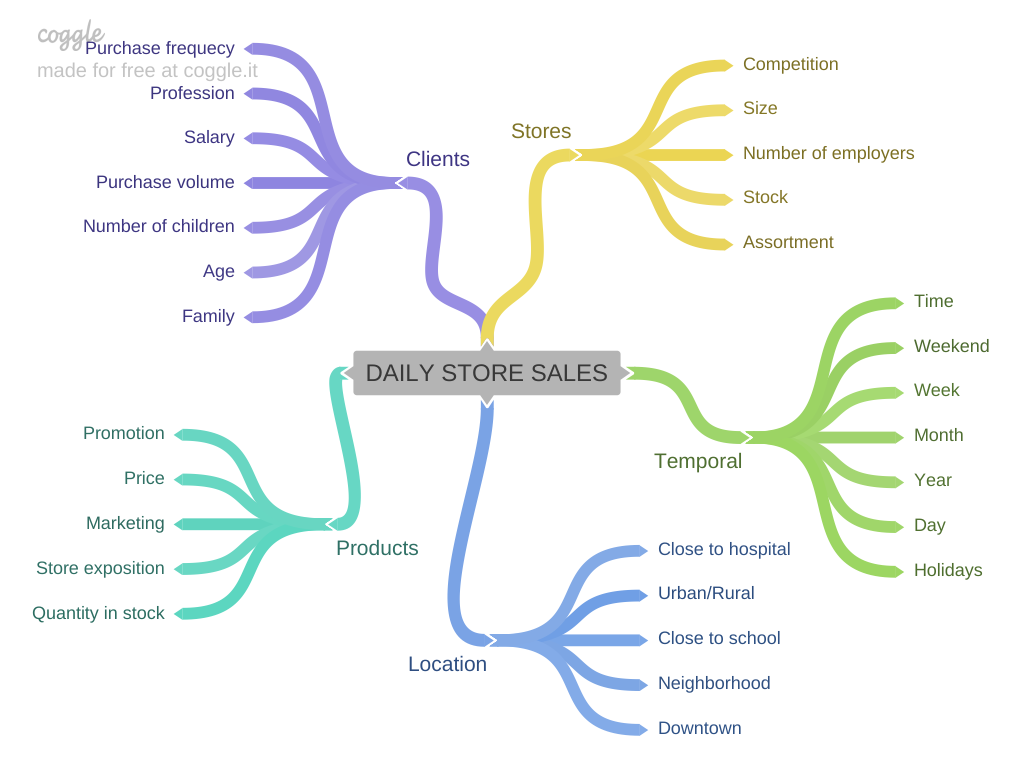

In [123]:
# Mind map hypotheses made with coggle
Image('img/mind_map_hypotheses.png')

## 2.2 Hypothesis Creation

### 2.1.1 Stores Hypotheses

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2 Products Hypotheses

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (maiores descontos) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Temporal Hypotheses

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Final List of Hypotheses (Based on dataset)

**1.** Lojas com com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais que outros feriados.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender mais aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [124]:
df2 = df1.copy()

In [125]:
# Feature year
df2['year'] = df2['date'].dt.year

# Feature month
df2['month'] = df2['date'].dt.month

# Feature day
df2['day'] = df2['date'].dt.day

# Feature week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
df2['week_of_year'] = df2['week_of_year'].astype('int32', copy=False)

# Feature year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [126]:
# Feature competition_since = The year and month are separated in the dataset, join them
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2.head()

# Feature competition_time_month = quantity of months since competition has been placed
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

In [127]:
# Feature promo_since = The year and week of the start of promo are separeted, join them
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

# Feature promo_time_week = Difference between the sale date and the promo extended started date
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
# If the column has negative values, the store is in regular promo
# If the column has positive values, the store is in extended promo 

In [128]:
# Feature assortment = Instead of a,b,c values, use basic,extra,extended values
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# Feature state_holiday = Instead of a,b,c,0 values, use public_holiday,easter_holyday,christmas_holiday,regular_day values
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas_holiday' if x=='c' else 'regular_day')

# 3.0 Variables Filter

In [129]:
df3 = df2.copy()
df3

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,public_holiday,1,a,...,1,2013,1,1,1,2013-00,2014-06-01,-18,2013-07-29,-30
1017205,1112,2,2013-01-01,0,0,0,0,public_holiday,1,c,...,0,2013,1,1,1,2013-00,2006-04-01,82,2012-12-31,0
1017206,1113,2,2013-01-01,0,0,0,0,public_holiday,1,a,...,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0
1017207,1114,2,2013-01-01,0,0,0,0,public_holiday,1,a,...,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


## 3.1 Row Filter

In [130]:
# Column 'open' == 0: closed Stores are not important for our case
# Column 'sales' == 0: are not relevant for our case
df3 = df3[(df3['open']==1) & (df3['sales']>0)]

## 3.2 Columns Selection

In [131]:
# Column 'customers': business restriction, can't use it. Could do a side project to find the likely number of customers for the next days.
# Column 'open': The attribute is full of 1's. Not usefull.
# Column 'month_map': Already used in feature engineering.
# Column 'promo_interval': Already used in feature engineering.
cols_drop = ['customers', 'open', 'month_map', 'promo_interval']
df3 = df3.drop(columns=cols_drop, axis=1)

# 4.0 EDA - Exploratory Data Analysis

In [132]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Numerical Variables

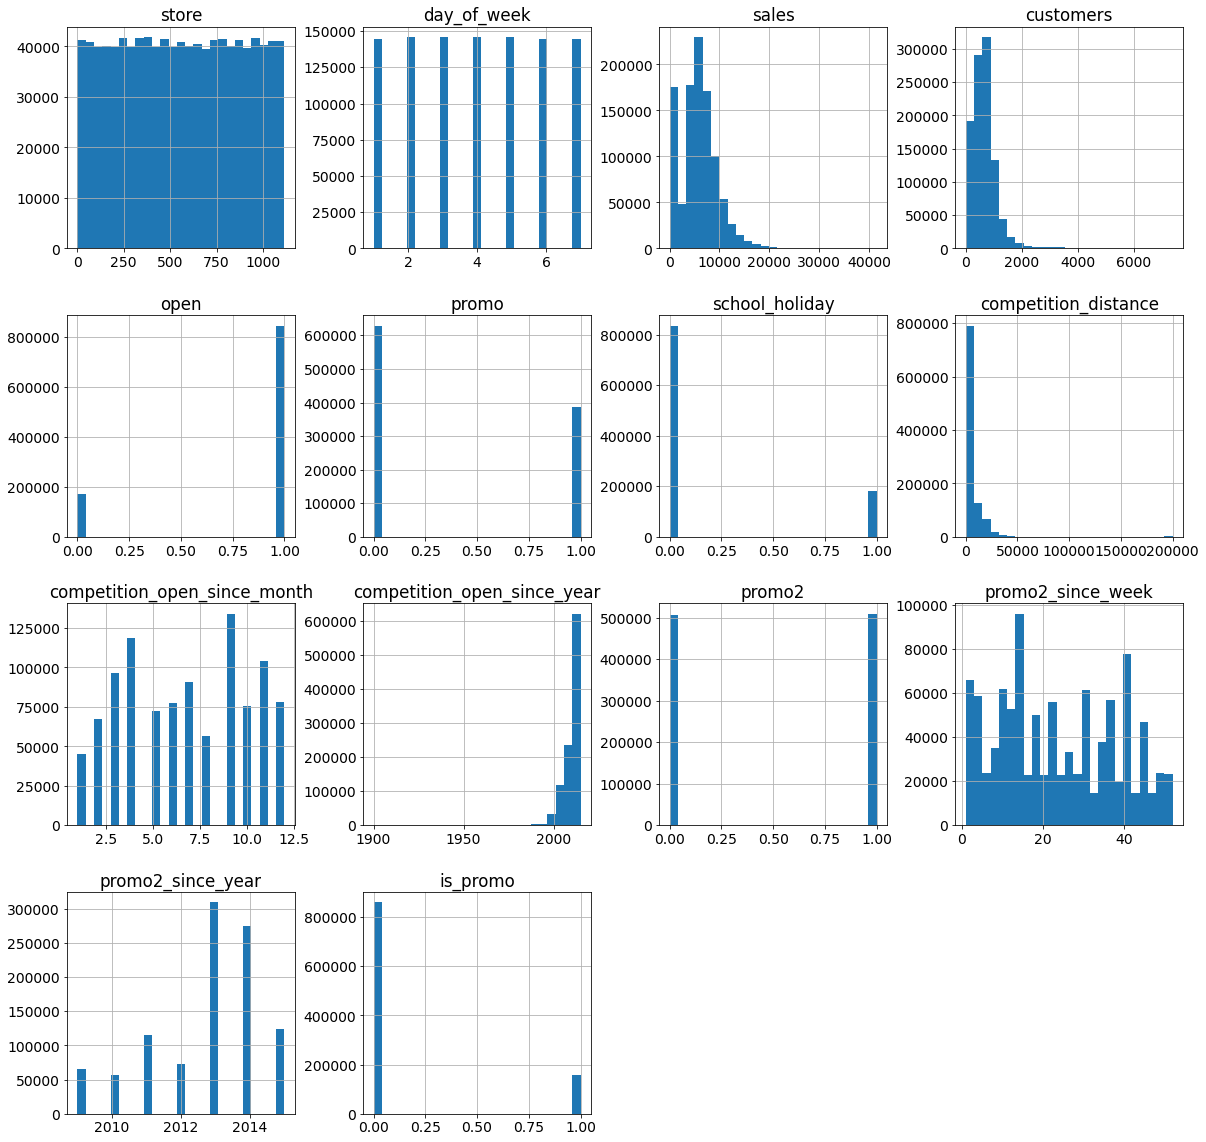

In [133]:
# Plot histograms
num_attributes.hist(figsize=(20,20), bins=25);

### 4.1.2 Categorical Variables

In [134]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


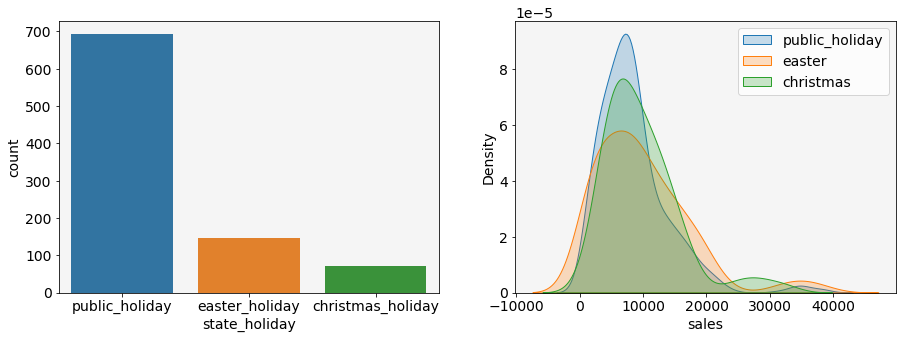

In [135]:
## Cat. 'state_holiday'

# Drop duplicates rows
df4['state_holiday'].drop_duplicates()

# Filter regular_day
aux = df4[df4['state_holiday'] != 'regular_day']

# Subplot - countplot | kdeplot
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(x=aux['state_holiday']).set_facecolor('whitesmoke');
plt.subplot(1,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'], shade=True, label='public_holiday').set_facecolor('whitesmoke');
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'], shade=True, label='easter');
sns.kdeplot(df4[df4['state_holiday']=='christmas_holiday']['sales'], shade=True, label='christmas');
plt.legend();


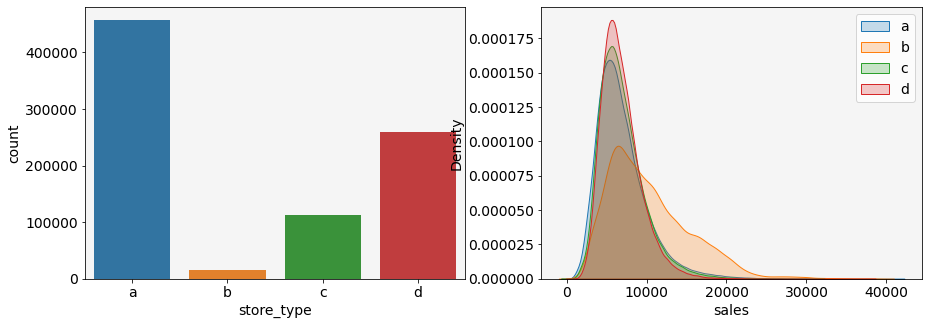

In [136]:
## Cat. 'store_type'

# Subplot - countplot | kdeplot
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(x=df4['store_type'].sort_values()).set_facecolor('whitesmoke');
plt.subplot(1,2,2)
sns.kdeplot(df4[df4['store_type']=='a']['sales'], shade=True, label='a').set_facecolor('whitesmoke');
sns.kdeplot(df4[df4['store_type']=='b']['sales'], shade=True, label='b');
sns.kdeplot(df4[df4['store_type']=='c']['sales'], shade=True, label='c');
sns.kdeplot(df4[df4['store_type']=='d']['sales'], shade=True, label='d');
plt.legend();

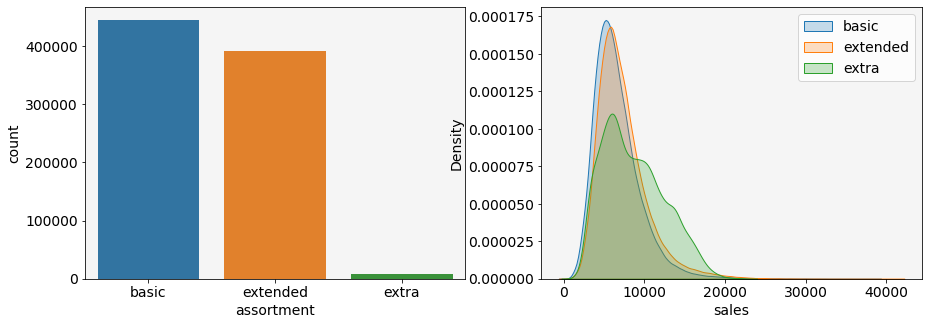

In [137]:
## Cat. 'assortment'

# Subplot - countplot | kdeplot
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(x=df4['assortment'].sort_values()).set_facecolor('whitesmoke');
plt.subplot(1,2,2)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'], shade=True, label='basic').set_facecolor('whitesmoke');
sns.kdeplot(df4[df4['assortment']=='extended']['sales'], shade=True, label='extended');
sns.kdeplot(df4[df4['assortment']=='extra']['sales'], shade=True, label='extra');
plt.legend();

## 4.2 Bivariate Analysis

**H1. Lojas com com maior sortimentos deveriam vender mais.**

**Falsa.** Lojas com maior sortimentos vendem menos.


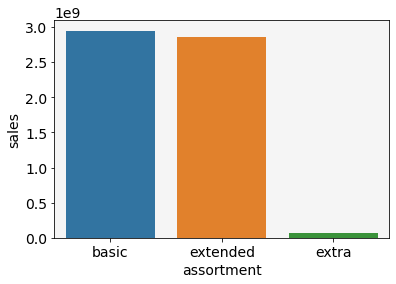

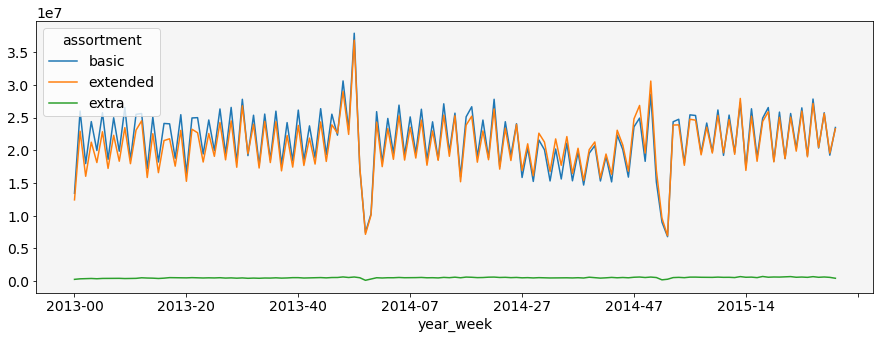

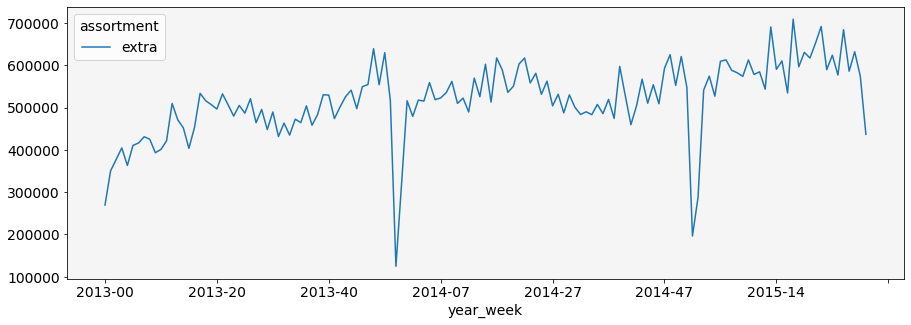

In [138]:
# Grouping sales by assortment
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

# Plot sales by assortment
sns.barplot(x=aux1['assortment'], y=aux1['sales']).set_facecolor('whitesmoke');

# Plot sales by assortment and by year_week to check a temporal behavior
aux2 = df4[['assortment', 'sales', 'year_week']].groupby(['year_week', 'assortment']).sum().reset_index()
aux3 = aux2.pivot(index='year_week', columns='assortment', values='sales')
aux3.plot(figsize=(15,5)).set_facecolor('whitesmoke')

# Check temporal behavior of 'extra' class sales
aux4 = aux2[aux2['assortment']=='extra']
aux4 = aux4.pivot(index='year_week', columns='assortment', values='sales')
aux4.plot(figsize=(15,5)).set_facecolor('whitesmoke')

**H2. Lojas com competidores mais próximos deveriam vender menos.**

**Falsa.** Lojas com competidores mais próximos, vendem mais.

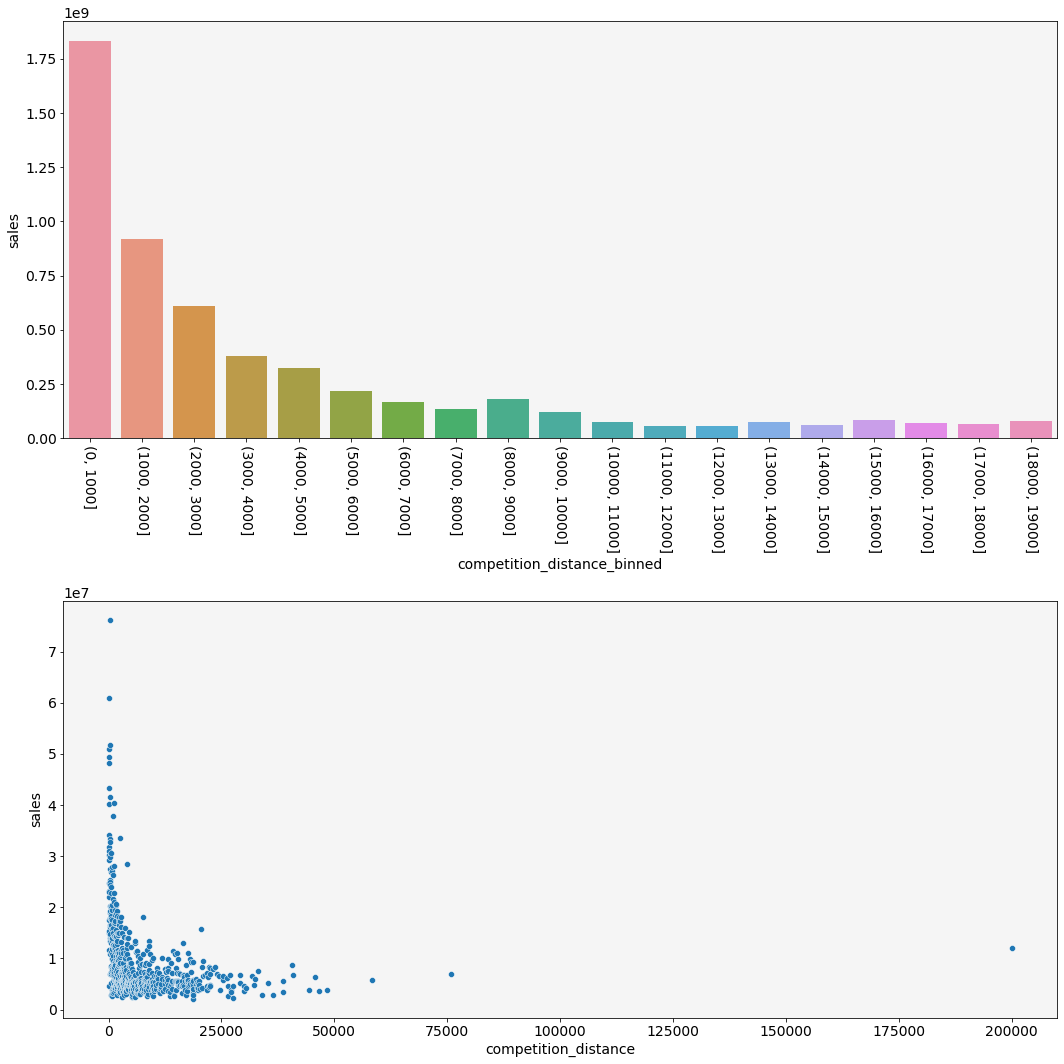

In [139]:
# Group by competition_distance 
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Create a list of bins to agroup in a new column
bins = list(np.arange(0,20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

# Bar plot
fig = plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
sns.barplot(x=aux2['competition_distance_binned'], y=aux2['sales']).set_facecolor('whitesmoke');
plt.xticks(rotation=270);

# Scatter plot 
plt.subplot(2,1,2)
sns.scatterplot(x=aux1['competition_distance'], y=aux1['sales']).set_facecolor('whitesmoke');
fig.tight_layout()

**H3. Lojas com competidores a mais tempo deveriam vender mais.**

**Falsa.** Lojas com competidores a mais tempo, vendem menos. Obs: Tendência de crescimento de lojas a mais tempo sem competidores até o primeiro competidor próximo.

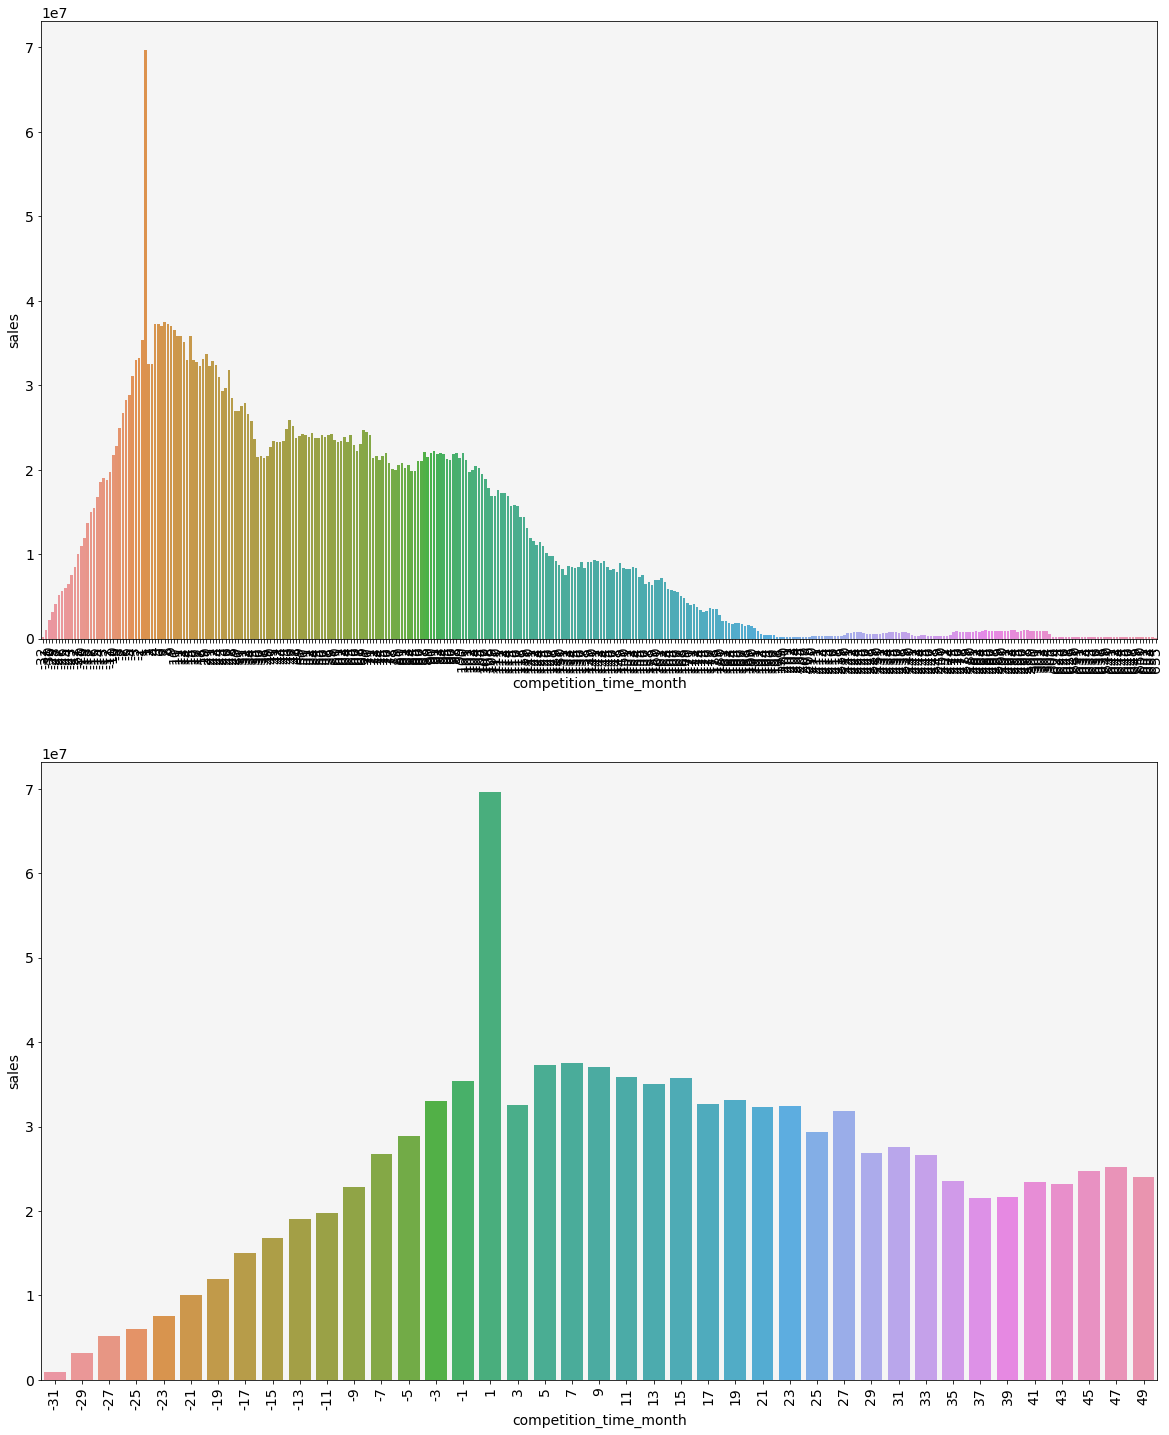

In [140]:
# Group by competition_time_month
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

# Filter: values < 1000 and != 0
aux1 = aux1[(aux1['competition_time_month']<1000) & (aux1['competition_time_month']!=0)]

# Barplot of a range of 1000 months
plt.figure(figsize=(20,25))
plt.subplot(2,1,1)
sns.barplot(x=aux1['competition_time_month'], y=aux1['sales']).set_facecolor('whitesmoke');
plt.xticks(rotation=90);


# Barplot of a range of 50 months
aux2 = aux1[(aux1['competition_time_month']<50) & aux1['competition_time_month']!=0]
plt.subplot(2,1,2)
sns.barplot(x=aux2['competition_time_month'], y=aux2['sales']).set_facecolor('whitesmoke');
plt.xticks(rotation=90);

**H4. Lojas com promoções ativas por mais tempo deveriam vender mais.**

**Falsa.** Lojas depois de um certo perído de tempo de promoção, vendem menos. (Checar correlação - heatmap no ínicio desta sessão)

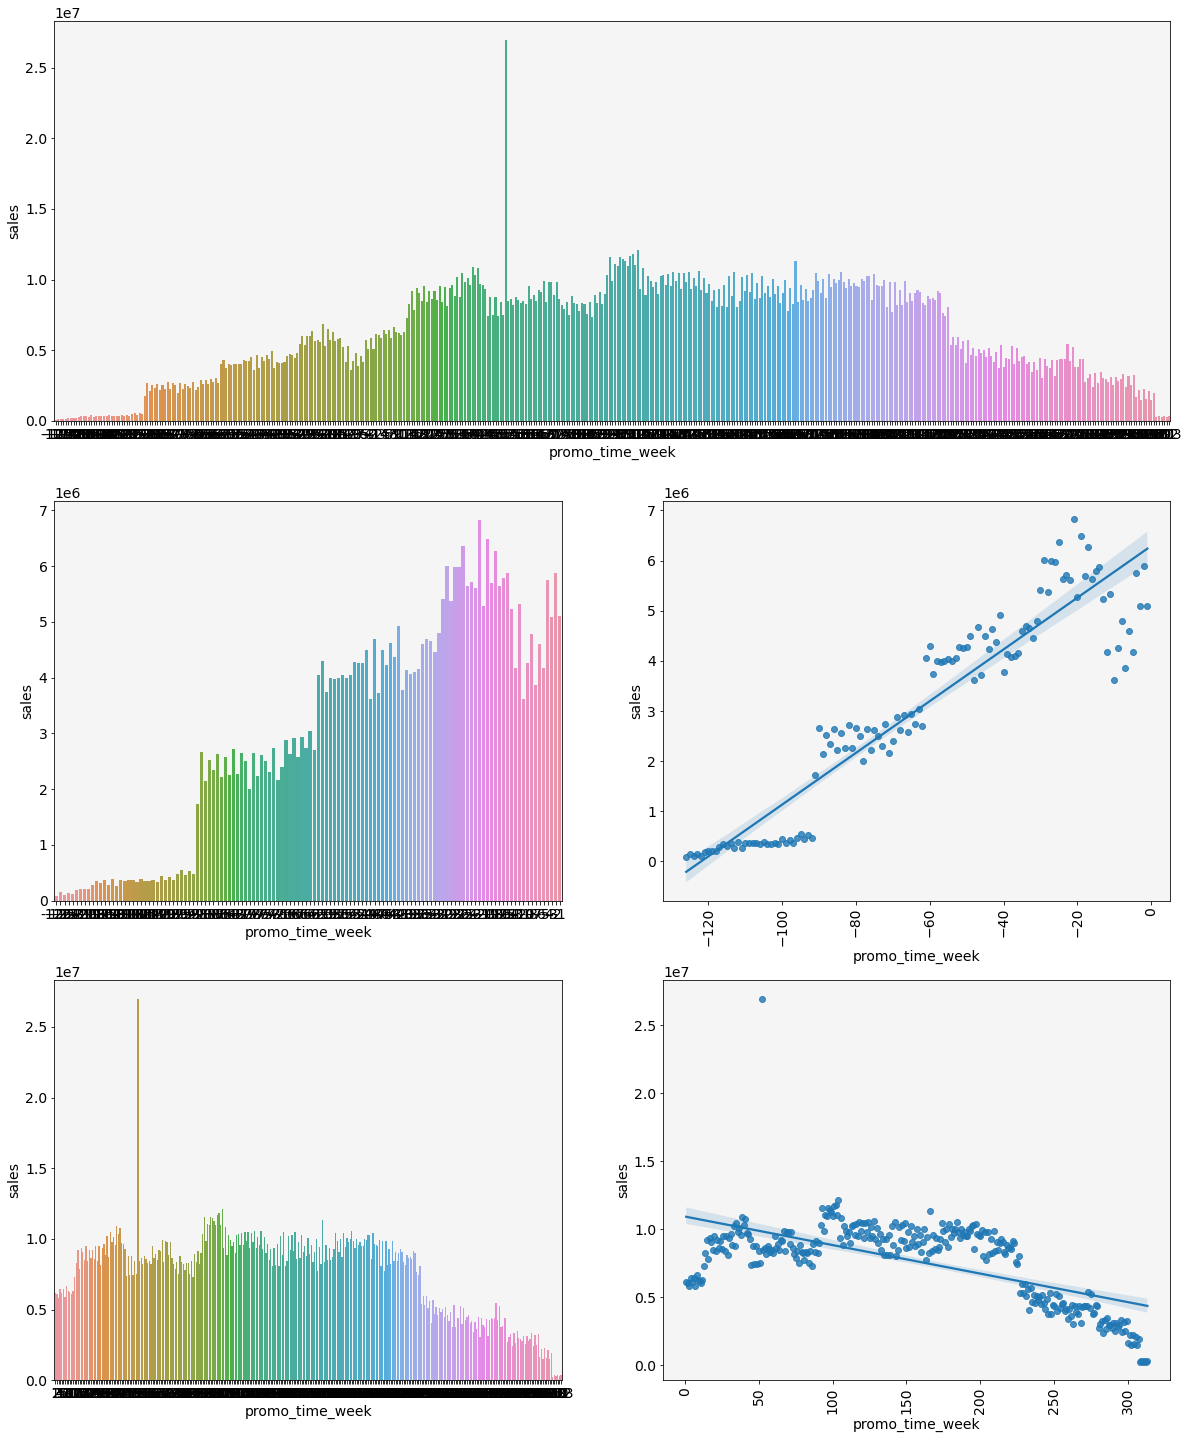

In [141]:
# Group by promo_time_week
aux1= df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# Filter values != 0
aux1 = aux1[aux1['promo_time_week']!=0]

grid = gs.GridSpec(3,2)

# First Barplot - Sales in regular promo and extended promo
plt.figure(figsize=(20,25))
plt.subplot(grid[0,:])
sns.barplot(x=aux1['promo_time_week'],y=aux1['sales']).set_facecolor('whitesmoke')

# Second Barplot - Sales in regular promo
aux2 = aux1[aux1['promo_time_week']<0]
plt.subplot(grid[1,0])
sns.barplot(x=aux2['promo_time_week'],y=aux2['sales']).set_facecolor('whitesmoke')
plt.subplot(grid[1,1])
sns.regplot(x=aux2['promo_time_week'],y=aux2['sales']).set_facecolor('whitesmoke')
plt.xticks(rotation=90);

# Third Barplot - Sales in extended promo
aux3 = aux1[aux1['promo_time_week']>0]
plt.subplot(grid[2,0])
sns.barplot(x=aux3['promo_time_week'],y=aux3['sales']).set_facecolor('whitesmoke')
plt.subplot(grid[2,1])
sns.regplot(x=aux3['promo_time_week'],y=aux3['sales']).set_facecolor('whitesmoke')
plt.xticks(rotation=90);

**H6. Lojas com mais promoções consecutivas deveriam vender mais.**

**Falsa.** Lojas com promoções consecutivas vendem menos.

In [142]:
# Check number of sales based on grouped by promo and promo2
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index().sort_values(by='sales')
#Highest number of sales is in stores that were participating only in promo (1,0)

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


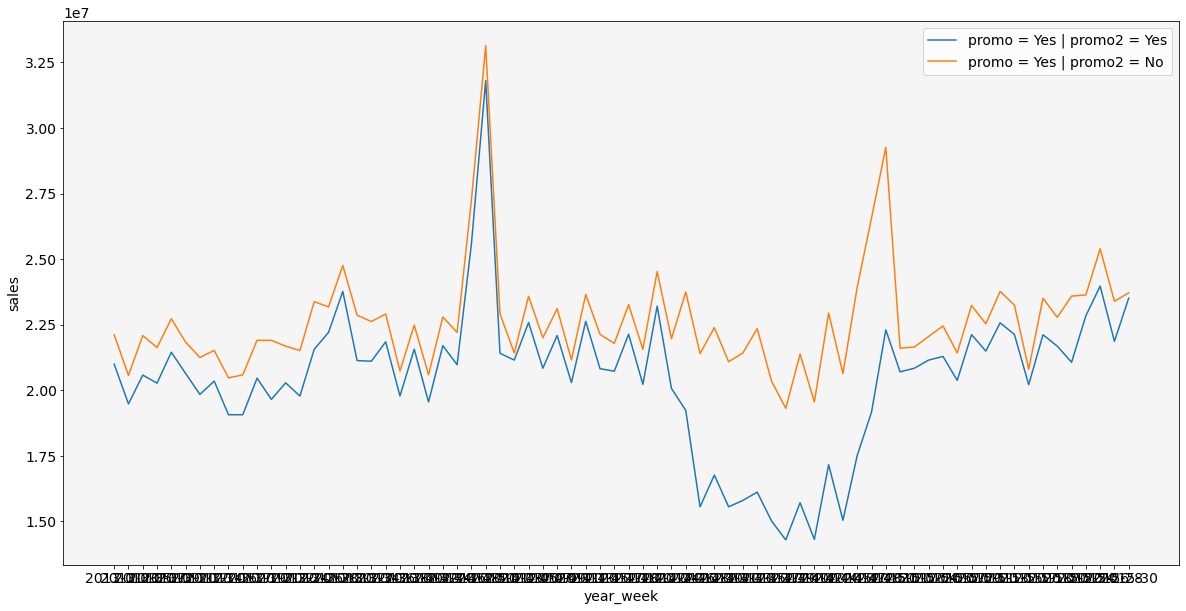

In [143]:
## Check the temporal behavior of sales based in promo and promo2

# Lineplot: promo = Yes | promo2 = Yes
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
plt.figure(figsize=(20,10));
sns.lineplot(x=aux1['year_week'], y=aux1['sales'], label='promo = Yes | promo2 = Yes').set_facecolor('whitesmoke');

# Lineplot: promo = Yes | promo2 = No
aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
sns.lineplot(x=aux2['year_week'], y=aux2['sales'], label='promo = Yes | promo2 = No').set_facecolor('whitesmoke');
#Checked that it's not worth it to extend the promotion
#The behavior is similar for each curve, that is a indication that the attribute could not be great to our model

**H7. Lojas abertas durante o feriado de Natal deveriam vender mais que outros feriados.**

**Falsa.** Lojas abertas durante o feriado de natal vendem menos que outros feriados.

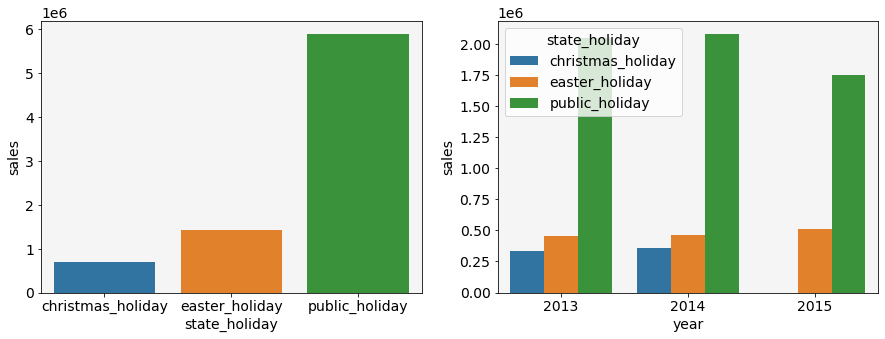

In [144]:
aux1 = df4[df4['state_holiday']!='regular_day'][['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(x=aux1['state_holiday'], y=aux1['sales']).set_facecolor('whitesmoke');

plt.subplot(1,2,2)
aux2 = df4[df4['state_holiday']!='regular_day'][['year', 'state_holiday','sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x=aux2['year'], y=aux2['sales'], hue=aux2['state_holiday']).set_facecolor('whitesmoke');

**H8. Lojas deveriam vender mais ao longo dos anos.**

**Falsa.** Lojas vendem menos ao longo dos anos.

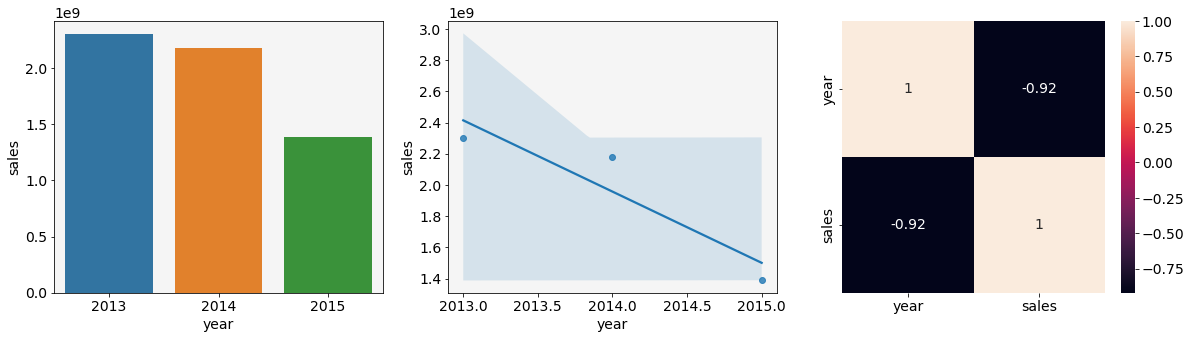

In [145]:
# Check sales grouped by year
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

# Barplot - Year of 2015 not completed
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1).set_facecolor('whitesmoke');
plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1).set_facecolor('whitesmoke');
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**H9. Lojas deveriam vender mais no segundo semestre do ano.**

**Falsa.** Na verdade, lojas vendem menos no segundo semestre.

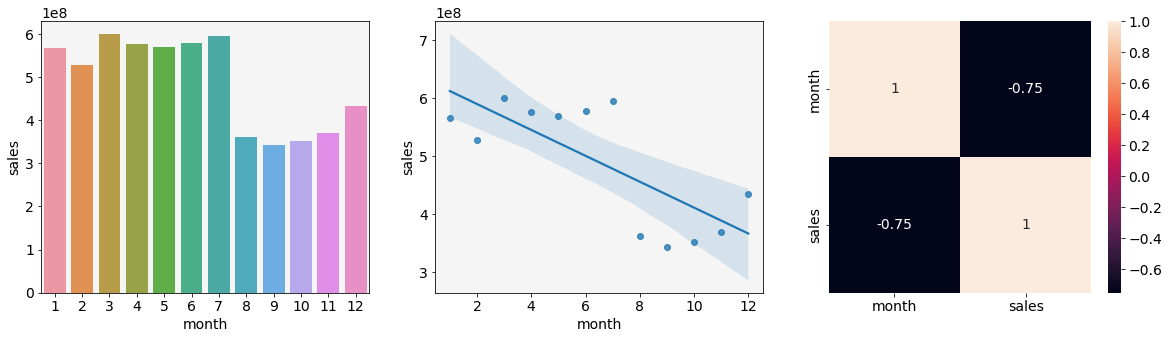

In [146]:
# Check sales grouped by month
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

# Barplot | Tendency | Correlation
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1).set_facecolor('whitesmoke');
plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1).set_facecolor('whitesmoke');
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**H10. Lojas deveriam vender mais depois do dia 10 de cada mês.**

**Verdadeiro.** Lojas vendem mais depois do dia 10 (apesar de não ser uma comparação justa 10x20 dias).

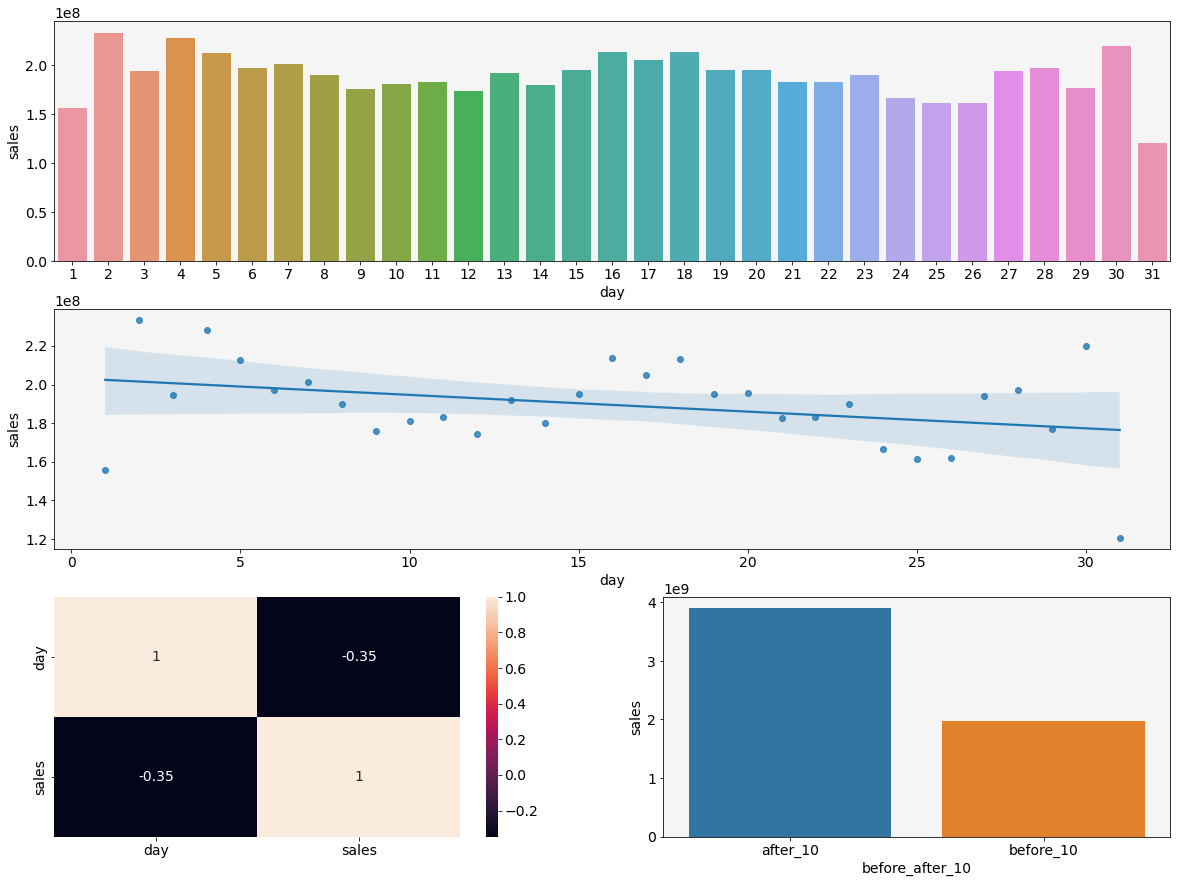

In [147]:
# Check sales grouped by day
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()


# Barplot and Correlation
grid = gs.GridSpec(3,2)
plt.figure(figsize=(20,15)) 
plt.subplot(grid[0,:])
sns.barplot(x='day', y='sales', data=aux1).set_facecolor('whitesmoke');
plt.subplot(grid[1,:])
sns.regplot(x='day', y='sales', data=aux1).set_facecolor('whitesmoke');
plt.subplot(grid[2,0])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

# Check before_10_day | after_10_day
aux1['before_after_10'] = aux1['day'].apply(lambda x: 'after_10' if x>10 else 'before_10')
aux2 = aux1[['before_after_10','sales']].groupby('before_after_10').sum().reset_index()
plt.subplot(grid[2,1])
sns.barplot(x='before_after_10', y='sales', data=aux2).set_facecolor('whitesmoke');

**H11. Lojas deveriam vender mais aos finais de semana.**

**Falsa.** Lojas vendem menos aos finais de semana. 

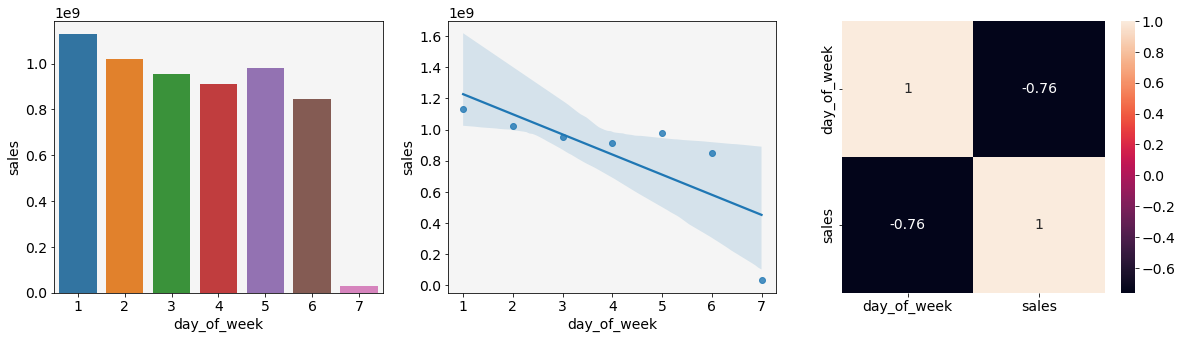

In [148]:
# Check sales grouped by day_of_week
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

# Barplot | Tendency | Correlation
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1).set_facecolor('whitesmoke');
plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1).set_facecolor('whitesmoke');
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**H12. Lojas deveriam vender menos durante os feriados escolares.**

**Verdadeiro.** Existem muito mais dias regulares que feriados escolares. Com exceção do mês de julho e agosto.

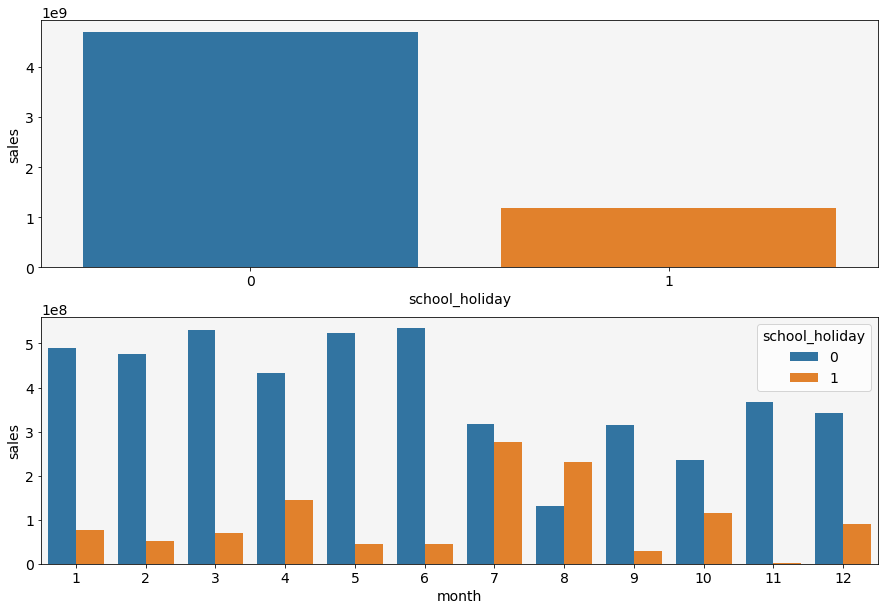

In [149]:
# Check sales grouped by school_holiday
aux = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

# Barplot 
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux).set_facecolor('whitesmoke');

# Check sales grouped by month and school_holiday
aux2 = df4[['school_holiday', 'sales', 'month']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2).set_facecolor('whitesmoke');
#month = 7, 8: July and August can be explained by school vacation

In [150]:
# Hypotheses summary
tab = [['Hipoteses', 'Conclusao', 'Relevancia'], 
       ['H1', 'Falsa', 'Baixa'], 
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Baixa
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attriburtes

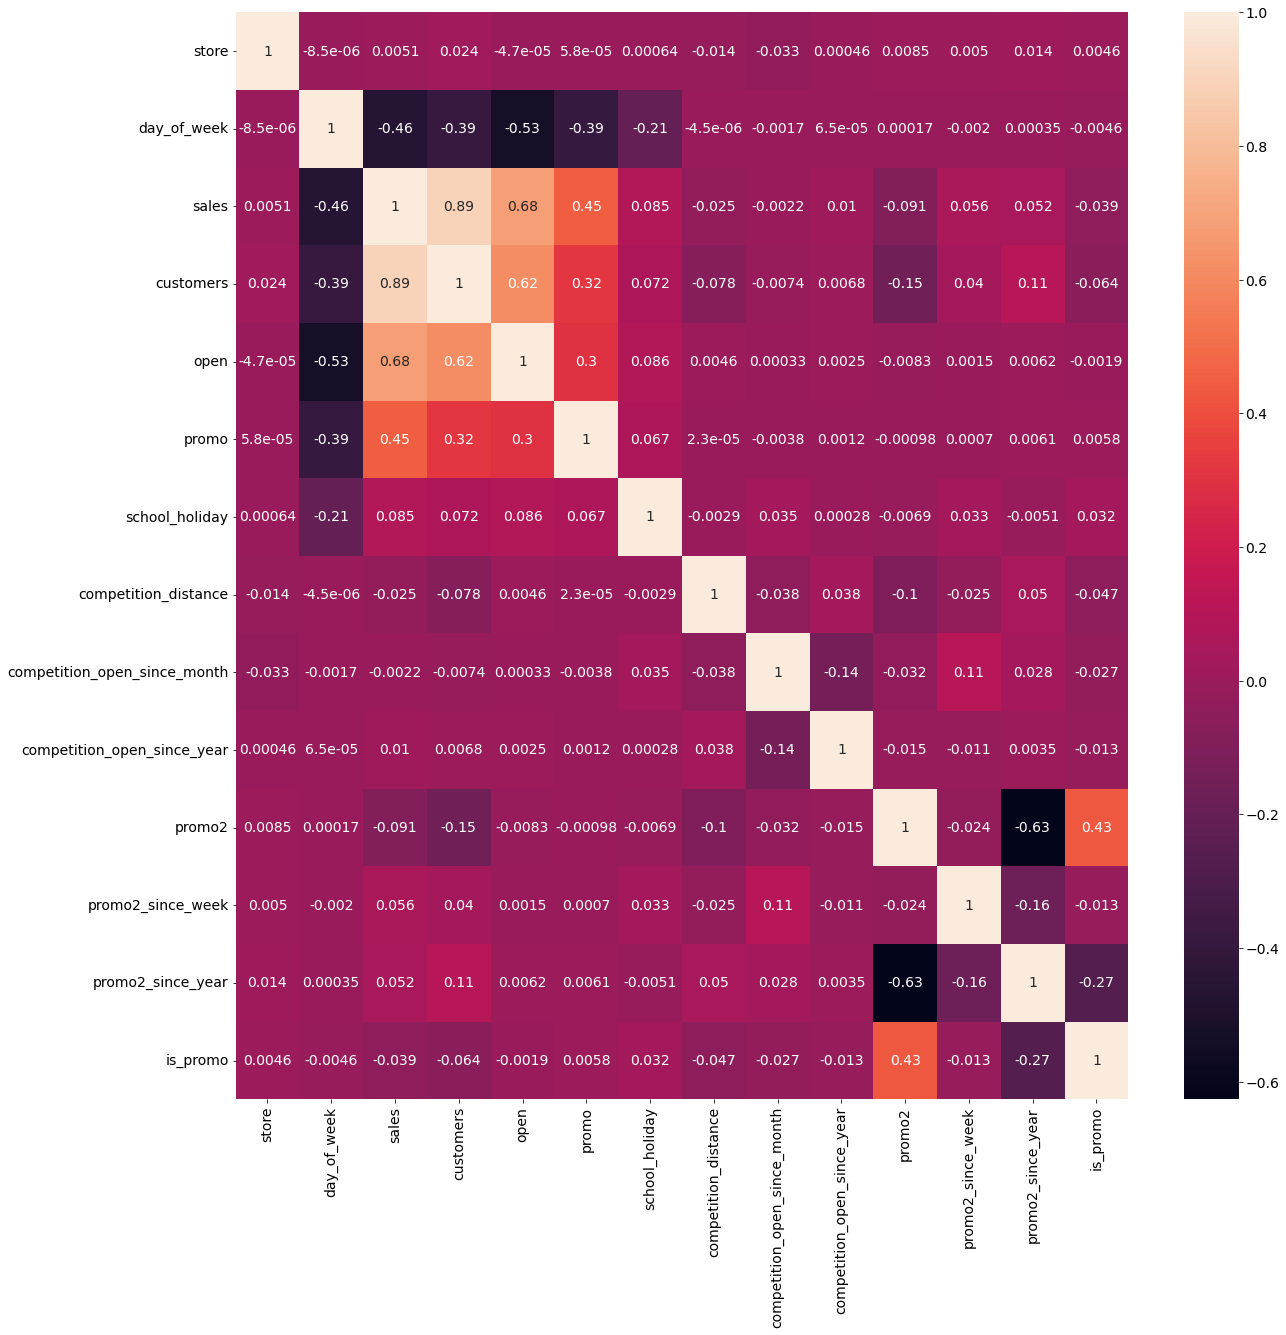

In [151]:
# Check correlations between numerical variables with a heat map
corr1 = num_attributes.corr(method='pearson')
plt.figure(figsize=(20,20))
sns.heatmap(corr1, annot=True);

### 4.3.2 Categorical Attributes

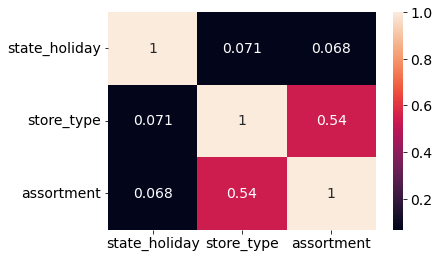

In [152]:
# Update the cat_attributes
a = df4.select_dtypes( include='object' )

# Calculate cramer V - Statistical method for categorical variables (see helper function)
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Construct the heatmap
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True );

# 5.0 Data Preparation

In [153]:
df5 = df4.copy()

## 5.1 Normalization

- Checking the behavior of numerical attributes in section 4.1, it's possible to notice that none of the attributes is normal. Then, none will be normalized. Rescalling instead.

## 5.2 Rescaling 

In [154]:
# Create a numerical variables df
num_attributes = df5.select_dtypes(include=['int64', 'int32', 'float64', 'float32'])

# Call Function: descriptive statistical metrics
metrics(num_attributes)

,%missing,uniques,%unique,data_types,mean,median,std,min,max,skew,kurtosis
store,0.00,1115,0.13,int64,558.42,558.00,321.73,1.00,1115.00,0.00,-1.20
day_of_week,0.00,7,0.00,int64,3.52,3.00,1.72,1.00,7.00,0.02,-1.26
sales,0.00,21733,2.57,int64,6955.96,6369.00,3103.82,46.00,41551.00,1.59,4.85
promo,0.00,2,0.00,int64,0.45,0.00,0.50,0.00,1.00,0.22,-1.95
school_holiday,0.00,2,0.00,int64,0.19,0.00,0.40,0.00,1.00,1.55,0.41
competition_distance,0.00,655,0.08,float64,5961.83,2330.00,12592.18,20.00,200000.00,10.13,145.29
competition_open_since_month,0.00,12,0.00,int32,6.79,7.00,3.31,1.00,12.00,-0.05,-1.23
competition_open_since_year,0.00,23,0.00,int32,2010.33,2012.00,5.50,1900.00,2015.00,-7.22,123.90
promo2,0.00,2,0.00,int64,0.50,0.00,0.50,0.00,1.00,0.01,-2.00
promo2_since_week,0.00,52,0.01,int32,23.63,22.00,14.29,1.00,52.00,0.17,-1.19


Checking the metrics, the rescaling could be usefull in variables with a big range min/max values, the outliers can be viewed in a box-plot:
- competition_distance
- competition_time_month
- promo_time_week
- year

In [155]:
# Use of the RobustScaler()
rs = RobustScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = rs.fit_transform(df5[['promo_time_week']].values)

# year (not cyclic) - Could use the MinMaxScaler
df5['year'] = rs.fit_transform(df5[['year']].values)

## 5.3 Transformation

In [156]:
df5.sample().T

,872169
store,1025
day_of_week,6
date,2013-05-11 00:00:00
sales,6096
promo,0
state_holiday,regular_day
school_holiday,0
store_type,a
assortment,basic
competition_distance,-0.26


### 5.3.1 Encoding

**Categorical Attributes into Numerical Attributes**
- state_holiday
- store_type
- assortment

In [157]:
# Enconding | state_holiday | One-Hot-Enconding method
df5 = pd.get_dummies(data=df5, columns=['state_holiday'])

# Enconding | store_type | Label Enconding method
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# Enconding | assortment | Ordinal Enconding
dict_assortment = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(dict_assortment)

### 5.3.2 Response Variable Transformation
- The transformation of magnitude of the response variable is interesting, because it approach the normal distribution, which increase the accuracy of the ML model.

In [158]:
# Log Transformation
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

**Cyclical variables can be transformed into a circle, where the notion of proximity is given by the distances and angles in the circle.**
- day_of_week
- month
- day
- week_of_year

In [159]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2*np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2*np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2*np.pi/52)))

In [160]:
df5.sample().T

,780836
store,7
day_of_week,3
date,2013-07-31 00:00:00
sales,9.63
promo,1
school_holiday,1
store_type,0
assortment,3
competition_distance,3.50
competition_open_since_month,4


## 5.4 Drop Columns

In [161]:
# As new derived columns were created, it is necessary to drop the old ones
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df5 = df5.drop(cols_drop, axis=1)

# 6.0 Feature Selection

In [162]:
df6 = df5.copy()
df6

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.57,1,1,2,1,-0.17,9,2008,...,0,1,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82
1,2,2015-07-31,8.71,1,1,0,1,-0.28,11,2007,...,0,1,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82
2,3,2015-07-31,9.03,1,1,0,1,1.90,12,2006,...,0,1,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82
3,4,2015-07-31,9.55,1,1,2,3,-0.28,9,2009,...,0,1,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82
4,5,2015-07-31,8.48,1,1,0,1,4.45,4,2015,...,0,1,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2013-01-01,8.12,0,1,1,1,-0.35,9,2006,...,1,0,0.97,-0.22,0.50,0.87,0.21,0.98,0.12,0.99
1016827,733,2013-01-01,9.28,0,1,1,2,-0.24,10,1999,...,1,0,0.97,-0.22,0.50,0.87,0.21,0.98,0.12,0.99
1016863,769,2013-01-01,8.52,0,1,1,2,-0.24,1,2013,...,1,0,0.97,-0.22,0.50,0.87,0.21,0.98,0.12,0.99
1017042,948,2013-01-01,8.41,0,1,1,2,-0.15,1,2013,...,1,0,0.97,-0.22,0.50,0.87,0.21,0.98,0.12,0.99


## 6.1 Split Dataframe into training and test

- The goal is to predict the next 6 weeks of sales. So, the dataset will be split:
    - Training data: until the last 6 weeks.
    - Test data: the last 6 weeks ahead.

In [163]:
# Check the limit date to split
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [164]:
# Training data
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# Test data
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print('Training Min Date: {}.'.format(x_train['date'].min()))
print('Training Max Date: {}.'.format(x_train['date'].max()))

print('\nTest Min Date: {}.'.format(x_test['date'].min()))
print('Test Max Date: {}.'.format(x_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00.
Training Max Date: 2015-06-18 00:00:00.

Test Min Date: 2015-06-19 00:00:00.
Test Max Date: 2015-07-31 00:00:00.


##  6.2 Boruta as Feature Selector
- Boruta is a feature selector, which calculate the importance of each feature in a model, and decide weather a feature stays or is discarded;
- Boruta does not work with dataframes = use .values;
- It is necessary to instantiate a model to use in Boruta.
- Boruta can take very long to run, so after the first run, save the info and input manually.

In [165]:
# Training and Test dataset for Boruta
#x_train_n = x_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values

# Instantiate the model
#rf = RandomForestRegressor(n_jobs=-1)  # n_jobs=-1 == Use all the cores of the pc to work in parallel (faster)

# Define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

In [166]:
# Best Features from Boruta | Need again the dataframe x_train
#cols_selected = boruta.support_
#x_train_fs = x_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
#cols_selected_boruta

In [167]:
# Not selected Features from Boruta
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))
#cols_not_selected_boruta

## 6.3 Manual Feature Selection

In [168]:
# Manually input the features selected by boruta
# Add the pair of dummies variabels 
# Add 'sales' and 'date' for future changes
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# Columns to add in part 7.7
cols_to_add = ['date', 'sales']
cols_all = cols_selected_boruta.copy()
cols_all.extend(cols_to_add)
cols_all

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0 Machine Learning Modeling

In [169]:
# Get selected columns from boruta 
x_train2 = x_train[cols_selected_boruta]
x_test2 = x_test[cols_selected_boruta]

## 7.1 Average Model

In [170]:
# Reconstruct the full df to group and find the mean of each store
aux1 = x_test2.copy()
aux1['sales'] = y_test.copy()

# Prediction of each store = mean
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})

# Merge prediction
aux1 = pd.merge(aux1, aux2, how='left', on='store')

# y_pred of each row
y_hat = aux1['predictions']

# Check the performance - NOTE: the y_pred and y_test was changed to log format, to return to normal apply np.expm1
baseline_result = ml_error('Average Model', y=np.expm1(y_test), y_hat=np.expm1(y_hat))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80,0.46,1835.14


## 7.2 Linear Regression Model

In [171]:
# Instantiate the model
lr = LinearRegression()
lr.fit(x_train2, y_train)

# Prediction of the model
y_hat_lr = lr.predict(x_test2)

# Check performance
lr_result = ml_error('Linear Regression', y=np.expm1(y_test), y_hat = np.expm1(y_hat_lr))
lr_result

#NOTE: The Linear Regression RMSE is higher than the average model RSME, it means the data has not a linear behavior

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.09,0.29,2671.05


## 7.3 Linear Regression Regularized Model - Lasso

In [172]:
# Instantiate the model
lrr = Lasso(alpha=0.01)        # alpha = constant multiplier, default = 0 is equivalent to the LinearRegression
lrr.fit(x_train2, y_train)

# Prediction of the model
y_hat_lrr = lrr.predict(x_test2)

# Check performance
lrr_result = ml_error('Linear Regression - Lasso', y=np.expm1(y_test), y_hat = np.expm1(y_hat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70,0.29,2744.45


## 7.4 Random Forest Regressor

In [173]:
# Instantiate the model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)   #n_estimators = number of trees, n_jobs = The number of jobs to run in parallel.   
rf.fit(x_train2, y_train)

# Prediction of the model
y_hat_rf = rf.predict(x_test2)

# Check performance
rf_result = ml_error('Random Forest Regressor', y=np.expm1(y_test), y_hat = np.expm1(y_hat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.60,0.10,1011.09


## 7.5 XGBoost Regressor

In [174]:
# Instantiate the model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', #Regression problem
                             n_estimators=100,             #The number of trees in the ensemble
                             eta=0.01,                     #The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller
                             max_depth=10,                 #Max depth of the tree
                             subsample=0.7,                 #Subsample ratio of the training instance.
                             colsample_bytree=0.9)         #Subsample ratio of columns when constructing each tree.
model_xgb.fit(x_train2, y_train)

# Prediction of the model
y_hat_xgb = model_xgb.predict(x_test2)

# Check performance
xgb_result = ml_error('XGBoost Regressor', y=np.expm1(y_test), y_hat = np.expm1(y_hat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.42,0.95,7330.69


## 7.6 Compare Model's Performance (not the real one)

In [175]:
model_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
model_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.60,0.10,1011.09
0,Average Model,1354.80,0.46,1835.14
0,Linear Regression,1867.09,0.29,2671.05
0,Linear Regression - Lasso,1891.70,0.29,2744.45
0,XGBoost Regressor,6683.42,0.95,7330.69


## 7.7 CrossValidation - TimeSeries - Models Performance (real one)
- Split the validation size of 6 weeks - Call Function KFolds = 5
- Chosen = Random Forests Regression

In [176]:
# Get the train date with all the columns of boruta plus 'date', 'sales'
x_train_cv = x_train[cols_all]

In [177]:
# Linear Regression
lr_result_cv = cross_validation(kfold=5, x_training=x_train_cv, model_name='Linear Regression', model=lr)
lr_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


In [178]:
# Lasso
lrr_result_cv = cross_validation(kfold=5, x_training=x_train_cv, model_name='Lasso', model=lrr)
lrr_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


In [179]:
# Random Forests Regression
rf_result_cv = cross_validation(kfold=5, x_training=x_train_cv, model_name='Random Forests', model=rf)
rf_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Random Forests,836.63+/-217.12,0.12+/-0.02,1254.29+/-316.19


In [180]:
# XGBoost Regressor
xgb_result_cv = cross_validation(kfold=5, x_training=x_train_cv, model_name='XGBoost Regressor', model=model_xgb)
xgb_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,XGBoost Regressor,7049.21+/-588.65,0.95+/-0.0,7715.21+/-689.51


In [181]:
# Real Performance Cross-Validation
model_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
model_result_cv.sort_values('RMSE_CV')

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Random Forests,836.63+/-217.12,0.12+/-0.02,1254.29+/-316.19
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26
0,XGBoost Regressor,7049.21+/-588.65,0.95+/-0.0,7715.21+/-689.51


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [182]:
# Instantiate the model
rf = RandomForestRegressor(random_state=35)  

# Provide hyperparameters grid for a random search
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 10, num = 1)] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [10, 20, 30] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

# Grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Random Search application
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 5,
                               verbose=2,
                               random_state=35,
                               n_jobs = -1)

# Fit the model - Get a sample to minimize the time
x_train_random = x_train_cv.sample(100000)
y_train_random = x_train_random['sales']
x_train_random = x_train_random.drop(['date', 'sales'], axis=1)
rf_random.fit(x_train_random, y_train_random)

# This prints the contents of the parameters in the random grid
print ('Random grid: ', random_grid, '\n')

# Print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random grid:  {'n_estimators': [1], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 1, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False}  



## 8.2 Final Model

In [183]:
# Copy Best Parameters from 8.1
params_tuned = {'n_estimators': 30, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}

# Final Model RandomForests
rf_tuned = RandomForestRegressor(n_estimators= params_tuned['n_estimators'], 
                min_samples_split= params_tuned['min_samples_split'], 
                min_samples_leaf= params_tuned['min_samples_leaf'], 
                max_features= params_tuned['max_features'], 
                max_depth= params_tuned['max_depth'], 
                bootstrap= params_tuned['bootstrap'])

# Fit the final model
rf_tuned.fit(x_train2, y_train)

# Final Prediction
y_hat_tuned = rf_tuned.predict(x_test2)

# Final Performance
rf_result_tuned = ml_error(model_name='Random Forests', y=np.expm1(y_test), y_hat=np.expm1(y_hat_tuned))
rf_result_tuned

,Model Name,MAE,MAPE,RMSE
0,Random Forests,690.52,0.10,1026.14


In [190]:
# Save the model
pickle.dump(rf_tuned, open('C:/Users/Usuario/Desktop/Data_Science/PROJETOS_DATA_SCIENCE/Projeto_Rossmann/model/model_rossmann.pkl', 'wb'))

# 9.0 Translate and Interpretation of Error

In [185]:
df9 = x_test[cols_all]

# Reescale the log format to normal format
df9['sales'] = np.expm1(df9['sales'])
df9['prediction'] = np.expm1(y_hat_tuned)
df9

C:\Users\Usuario\AppData\Local\Temp\ipykernel_6424\3760737720.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_6424\3760737720.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['prediction'] = np.expm1(y_hat_tuned)


,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,...,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,date,sales,prediction
0,1,1,2,1,-0.17,9,2008,0,31,2015,...,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82,2015-07-31,5263.00,5412.50
1,2,1,0,1,-0.28,11,2007,1,13,2010,...,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82,2015-07-31,6064.00,6646.86
2,3,1,0,1,1.90,12,2006,1,14,2011,...,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82,2015-07-31,8314.00,9489.31
3,4,1,2,3,-0.28,9,2009,0,31,2015,...,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82,2015-07-31,13995.00,11641.12
4,5,1,0,1,4.45,4,2015,0,31,2015,...,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82,2015-07-31,4822.00,5778.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47940,1111,1,0,1,-0.07,6,2014,1,31,2013,...,-0.22,0.00,-1.00,-0.74,-0.67,0.12,-0.99,2015-06-19,5618.00,5726.15
47941,1112,1,2,3,-0.07,4,2006,0,25,2015,...,-0.22,0.00,-1.00,-0.74,-0.67,0.12,-0.99,2015-06-19,11240.00,11652.07
47942,1113,1,0,3,1.12,6,2015,0,25,2015,...,-0.22,0.00,-1.00,-0.74,-0.67,0.12,-0.99,2015-06-19,7114.00,6833.16
47943,1114,1,0,3,-0.24,6,2015,0,25,2015,...,-0.22,0.00,-1.00,-0.74,-0.67,0.12,-0.99,2015-06-19,21834.00,22958.48


## 9.1 Business Performance

In [186]:
# Get the sum of predictions by store
df9_1 = df9[['store', 'sales', 'prediction']].groupby('store').sum().reset_index()

# Calculate the MAE, MAPE
aux1 = df9[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['prediction'])).reset_index().rename(columns={0: 'MAE'})
aux2 = df9[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['prediction'])).reset_index().rename(columns={0: 'MAPE'})

# Merge dfs
aux3 = pd.merge(aux1, aux2, how='inner', on='store')
df9_2 = pd.merge(df9_1, aux3,  how='inner', on='store')

# Best and worst scenarios
df9_2['best_scenario'] = df9_2.apply(lambda x: x['prediction'] + x['MAE'], axis=1)
df9_2['worst_scenario'] = df9_2.apply(lambda x: x['prediction'] - x['MAE'], axis=1)
display(df9_2)

# Print an Example - Store 5
print('The store 5 has a prediction of sales for the next six weeks of ${:.2f}, with an error of {:.2f} %. \n' 
      'It means that, the best sceario for the store is ${:.2f} of sales. \n'
      'And the worst scenario is ${:.2f} of sales.'.format(df9_2['prediction'][4], df9_2['MAPE'][4]*100, df9_2['best_scenario'][4], df9_2['worst_scenario'][4]))

,store,sales,prediction,MAE,MAPE,best_scenario,worst_scenario
0,1,162320.00,164265.08,302.61,0.07,164567.70,163962.47
1,2,182936.00,181694.88,402.17,0.08,182097.05,181292.71
2,3,254190.00,264786.29,641.94,0.09,265428.24,264144.35
3,4,369378.00,354414.87,797.32,0.08,355212.19,353617.55
4,5,166905.00,172011.48,352.61,0.08,172364.09,171658.87
...,...,...,...,...,...,...,...
1110,1111,173854.00,182025.50,648.16,0.14,182673.66,181377.34
1111,1112,319237.00,346509.05,977.81,0.13,347486.85,345531.24
1112,1113,243427.00,243852.86,604.06,0.10,244456.92,243248.80
1113,1114,842724.00,786112.08,1944.60,0.08,788056.68,784167.49


The store 5 has a prediction of sales for the next six weeks of $172011.48, with an error of 8.37 %. 
It means that, the best sceario for the store is $172364.09 of sales. 
And the worst scenario is $171658.87 of sales.


,store,sales,prediction,MAE,MAPE,best_scenario,worst_scenario
291,292,137966.00,108796.98,3543.60,0.60,112340.58,105253.38
908,909,360069.00,246108.92,6981.23,0.48,253090.14,239127.69
549,550,192353.00,262994.55,1909.23,0.38,264903.78,261085.32
875,876,257556.00,213617.37,3909.23,0.31,217526.60,209708.14
721,722,279296.00,355694.70,2064.83,0.27,357759.53,353629.87


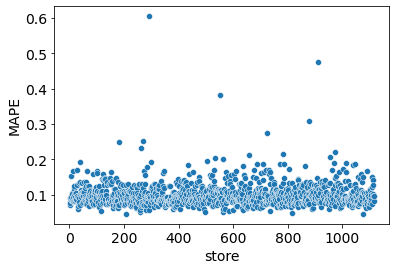

In [187]:
# Check the smallest MAPE stores
display(df9_2.sort_values('MAPE', ascending=False).head())
sns.scatterplot(x='store', y='MAPE', data=df9_2);

## 9.2 Machine Learning Performance

In [188]:
# Add error rate to plot
df9['error'] = df9['sales'] - df9['prediction']
df9['error_rate'] = df9['prediction']/df9['sales']

C:\Users\Usuario\AppData\Local\Temp\ipykernel_6424\20883111.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['prediction']
C:\Users\Usuario\AppData\Local\Temp\ipykernel_6424\20883111.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['prediction']/df9['sales']


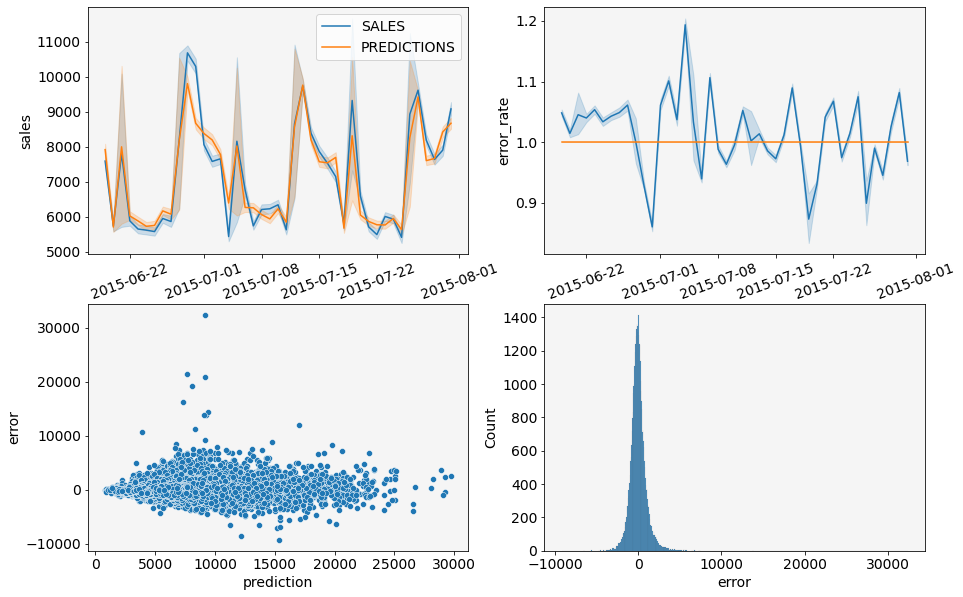

In [189]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES').set_facecolor('whitesmoke');
sns.lineplot(x='date', y='prediction', data=df9, label='PREDICTIONS').set_facecolor('whitesmoke');
plt.xticks(rotation=20);

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9).set_facecolor('whitesmoke');
sns.lineplot(x='date', y=1, data=df9);
plt.xticks(rotation=20);

plt.subplot(2,2,3)
sns.scatterplot(x=df9['prediction'], y=df9['error']).set_facecolor('whitesmoke');

plt.subplot(2,2,4)
sns.histplot(df9['error']).set_facecolor('whitesmoke');

**NOTES:**

- Graph 01: Predict and real sales are really close to each other. The shadow refers to the variance in each case.
- Graph 02: If == 1, the prediction was perfect. If > 1 is a underestimation. If < 1 is a superestimation.
- Graph 03: Used in residue analysis. Between 5000 and 10000 prediction values, the error is bigger.
- Graph 04: The distribution of the error has a gaussian distribution.